# Description

This notebook loads the result of running 100 iterations of the CPM algorithm on real data, and also those of running 10,000 iterations with randomized labels (null distribution).

Using these data, the notebook then computes non-parametric p-values for each prediction.

Finally, the notebook generates summary figures for the ability of CPM to predict experiential variables.

> **NOTE:** Although the notebook loads and computes values for the three CPM models (pos, neg and glm), ultimately on the paper we only report results for the glm case.

In [1]:
import pandas as pd
import os.path as osp
from utils.basics import RESOURCES_CPM_DIR
import hvplot.pandas
from tqdm import tqdm
import numpy as np
import pickle
from utils.basics import FB_400ROI_ATLAS_NAME
from cpm.plotting import plot_predictions
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

In [2]:
ACCURACY_METRIC      = 'pearson'
CORR_TYPE            = 'pearson'
E_SUMMARY_METRIC     = 'sum'
CONFOUNDS            = 'conf_residualized'
# How Behaviors are encoded so far
BEHAVIOR_LIST        = ['Factor1','Factor2','Vigilance','Images','Words','People','Myself','Positive','Negative','Surroundings','Intrusive','Future','Past','Specific']
# New labels for consistency with text descriptions
BEHAVIOR_LABELS_DICT = {'Factor1':'Thought Pattern 1','Factor2':'Thought Pattern 2','Vigilance':'Wakefulness',
                        'Images':'Images','Words':'Words','People':'People','Myself':'Myself','Positive':'Positive','Negative':'Negative','Surroundings':'Surroundings','Intrusive':'Intrusive','Future':'Future','Past':'Past','Specific':'Specific'}
BEHAVIOR_LABELS      = ['Thought Pattern 1','Thought Pattern 2','Wakefulness','Images','Words','People','Myself','Positive','Negative','Surroundings','Intrusive','Future','Past','Specific']
# Mode used for running CPM
SPLIT_MODE           = 'subject_aware'
# Atlas Selection
ATLAS                = FB_400ROI_ATLAS_NAME

## 1. Load CPM results

1.1. Real data

In [3]:
real_results_path = osp.join(RESOURCES_CPM_DIR,f'real-{ATLAS}-{SPLIT_MODE}-{CONFOUNDS}-{CORR_TYPE}_{E_SUMMARY_METRIC}.pkl')
with open(real_results_path,'rb') as f:
     real_predictions_xr = pickle.load(f)
Nbehavs, Niters_real, Nscans, Nresults = real_predictions_xr.shape
print(Nbehavs, Niters_real, Nscans, Nresults)

14 100 471 4


Updating Behavior coordinate dimensions for proper labeling of final figures so that they agree with the main text

In [4]:
real_predictions_xr = real_predictions_xr.assign_coords({'Behavior':[BEHAVIOR_LABELS_DICT[b] for b in real_predictions_xr.Behavior.values]})

1.2. Randomized data

In [5]:
null_results_path = osp.join(RESOURCES_CPM_DIR,f'null-{ATLAS}-{SPLIT_MODE}-{CONFOUNDS}-{CORR_TYPE}_{E_SUMMARY_METRIC}.pkl')

with open(null_results_path,'rb') as f:
     null_predictions_xr = pickle.load(f)
_, Niters_null, _, _ = null_predictions_xr.shape
print(Nbehavs, Niters_null, Nscans, Nresults)

14 10000 471 4


In [6]:
null_predictions_xr = null_predictions_xr.assign_coords({'Behavior':[BEHAVIOR_LABELS_DICT[b] for b in null_predictions_xr.Behavior.values]})

# 2. Compute accuracy values

2.1. Real data

In [8]:
%%time
accuracy_real = {BEHAVIOR:pd.DataFrame(index=range(Niters_real), columns=['Accuracy']) for BEHAVIOR in BEHAVIOR_LABELS}

p_values = pd.DataFrame(index=BEHAVIOR_LABELS,columns=['Non Parametric','Parametric'])

for BEHAVIOR in BEHAVIOR_LABELS:
    for niter in tqdm(range(Niters_real), desc=BEHAVIOR):
        observed  = pd.Series(real_predictions_xr.loc[BEHAVIOR,niter,:,'observed'].values)
        if E_SUMMARY_METRIC == 'ridge':
            predicted = pd.Series(real_predictions_xr.loc[BEHAVIOR,niter,:,'predicted (ridge)'].values)
        else:
            predicted = pd.Series(real_predictions_xr.loc[BEHAVIOR,niter,:,'predicted (glm)'].values)
        accuracy_real[BEHAVIOR].loc[niter]  = observed.corr(predicted, method=ACCURACY_METRIC)
        if ACCURACY_METRIC == 'pearson':
            _,p_values.loc[BEHAVIOR,'Parametric'] = pearsonr(observed,predicted)
        if ACCURACY_METRIC == 'spearman':
            _,p_values.loc[BEHAVIOR,'Parametric'] = spearmanr(observed,predicted)

Specific: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 624.47it/s]

CPU times: user 2.3 s, sys: 33.4 ms, total: 2.33 s
Wall time: 2.38 s


2.2. Null data

In [9]:
%%time
accuracy_null = {BEHAVIOR:pd.DataFrame(index=range(Niters_null), columns=['Accuracy']) for BEHAVIOR in BEHAVIOR_LABELS}
for BEHAVIOR in BEHAVIOR_LABELS:
    for niter in tqdm(range(Niters_null), desc=BEHAVIOR):
        observed  = pd.Series(null_predictions_xr.loc[BEHAVIOR,niter,:,'observed'].values)
        if E_SUMMARY_METRIC == 'ridge':
            predicted = pd.Series(null_predictions_xr.loc[BEHAVIOR,niter,:,'predicted (ridge)'].values)
        else:
            predicted = pd.Series(null_predictions_xr.loc[BEHAVIOR,niter,:,'predicted (glm)'].values)
        accuracy_null[BEHAVIOR].loc[niter]  = observed.corr(predicted, method=ACCURACY_METRIC)

Specific: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 720.29it/s]

CPU times: user 3min 13s, sys: 566 ms, total: 3min 14s
Wall time: 3min 14s


# 3. Compute non-parameter p-values

For this, we rely on the null distribution generated via label randomization. 

We use the formula on section 2.4.4 from Finn & Bandettini ["Movie-watching outperforms rest for functional connectivity-based prediction of behavior"](https://www.sciencedirect.com/science/article/pii/S1053811921002408) NeuroImage 2021

In [10]:
p_values.columns.name = 'p-value'
for BEHAVIOR in BEHAVIOR_LABELS:
    p_values.loc[BEHAVIOR,'Non Parametric'] = (((accuracy_null[BEHAVIOR] > accuracy_real[BEHAVIOR].median()).sum() + 1) / (Niters_null+1)).values[0]

# 4. Generate Prediction-reporting Figures

In [11]:
%%time
null_df = pd.DataFrame(columns=['Question','Iteration','R'])
for BEHAVIOR in BEHAVIOR_LABELS:
    for i in tqdm(range(Niters_null), desc=BEHAVIOR):
        null_df = null_df.append({'Question':BEHAVIOR,'Iteration':i,'R':accuracy_null[BEHAVIOR].loc[i].values[0]}, ignore_index=True)

Specific: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 300.45it/s]

CPU times: user 5min 38s, sys: 983 ms, total: 5min 39s
Wall time: 5min 40s


In [12]:
%%time
real_df = pd.DataFrame(columns=['Question','Iteration','R'])
for BEHAVIOR in BEHAVIOR_LABELS:
    for i in tqdm(range(Niters_real), desc=BEHAVIOR):
        real_df = real_df.append({'Question':BEHAVIOR,'Iteration':i,'R':accuracy_real[BEHAVIOR].loc[i].values[0]}, ignore_index=True)

Specific: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 621.08it/s]

CPU times: user 2.25 s, sys: 19 ms, total: 2.27 s
Wall time: 2.26 s


We will now save these summary views to disk, as we will need them on the next notebook that creates a dashboard that allows a comprehensive exploration of the CPM results.

In [13]:
output_path = osp.join(RESOURCES_CPM_DIR,f'cpm_predictions_summary-{SPLIT_MODE}-{CONFOUNDS}-{CORR_TYPE}.pkl')
outputs     = {'real_df':real_df,'null_df':null_df, 'accuracy_real': accuracy_real, 'accuracy_null':accuracy_null, 'p_values':p_values, 'real_predictions_xr':real_predictions_xr, 'null_predictions_xr':null_predictions_xr}
with open(output_path ,'wb') as f:
    pickle.dump(outputs,f)
print('++ INFO: Data written to disk [%s]' % output_path)

++ INFO: Data written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/cpm/cpm_predictions_summary-subject_aware-conf_residualized-pearson.pkl]


## 4.1. Without statistical annotations

> **NOTE:** Prior to doing anything else, we will update some labels so that figures are consistent with the descriptions in the main text. In particular: Vigilance --> Wakefulness, Factor1 --> Thought Pattern 1, and Factor2 --> Thought Pattern 2

In [16]:
median_width = 0.4
sns.set(style='whitegrid')

Text(0.5, 0, 'SNYCQ Item')

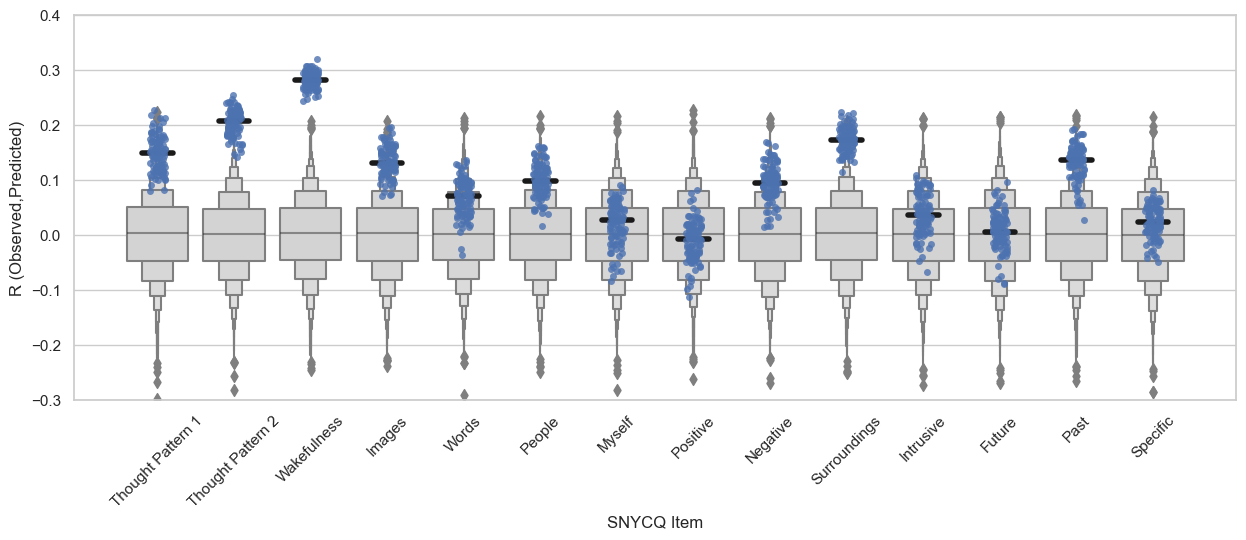

In [17]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
sns.boxenplot(data=null_df,x='Question',y='R', color='lightgray', ax=ax) 
sns.stripplot(data=real_df,x='Question', y='R', alpha=.8, ax=ax)
plt.xticks(rotation=45);
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    question   = text.get_text()
    median_val = accuracy_real[question].median().values[0]
    ax.plot([tick-median_width/2, tick+median_width/2],[median_val,median_val], lw=4, color='k')
ax.set_ylim(-.3,.4)
ax.set_ylabel('R (Observed,Predicted)');
ax.set_xlabel('SNYCQ Item')

## 4.2. With Statistical Annotations

Text(0.5, 0, 'SNYCQ Item')

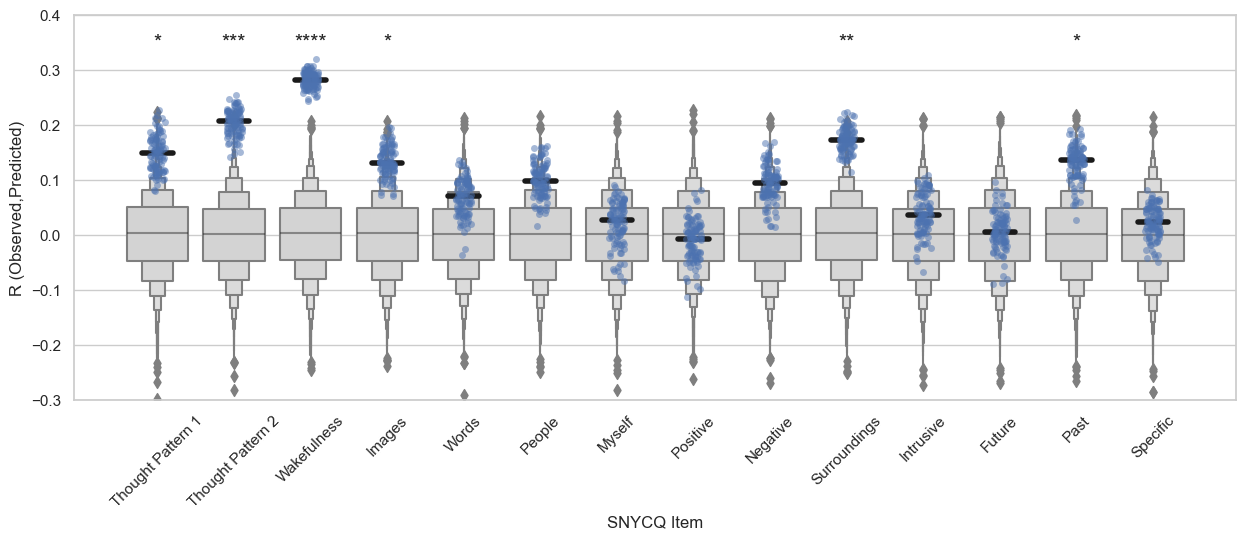

In [18]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
sns.boxenplot(data=null_df,x='Question',y='R', color='lightgray', ax=ax) 
sns.stripplot(data=real_df,x='Question', y='R', alpha=.5, ax=ax)
plt.xticks(rotation=45);
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    # Add Black Line Signaling Median
    question   = text.get_text()
    median_val = accuracy_real[question].median().values[0]
    ax.plot([tick-median_width/2, tick+median_width/2],[median_val,median_val], lw=4, color='k')
    # Statistical Significant Information
    p = p_values.loc[question,'Non Parametric']
    if 5.00e-02 < p <= 1.00e+00:
        annot = '' 
    elif 1.00e-02 < p <= 5.00e-02:
        annot = '*'
    elif 1.00e-03 < p <= 1.00e-02:
        annot = '**'
    elif 1.00e-04 < p <= 1.00e-03:
        annot = '***'
    elif p <= 1.00e-04:
        annot = '****'
    max_val = real_df.set_index('Question').max()['R']
    ax.annotate(annot, xy=(tick, max_val+0.02), ha='center', fontsize=15)
    
ax.set_ylim(-.3,.4)
ax.set_ylabel('R (Observed,Predicted)');
ax.set_xlabel('SNYCQ Item')

We will also plot the same results, but separated in three different panels. One for the wakefulness question, one for the two factors, and one for the 11 questions entering the Sparse Box-Constrained Non-Negative Matrix Factorization. This might come handy for presentations, yet it is exactly the same information as above.

Text(0, 0, 'Wakefulness') 0.28
Text(0, 0, 'Thought Pattern 1') 0.15
Text(1, 0, 'Thought Pattern 2') 0.21
Text(0, 0, 'Images') 0.13
Text(6, 0, 'Surroundings') 0.17
Text(9, 0, 'Past') 0.14


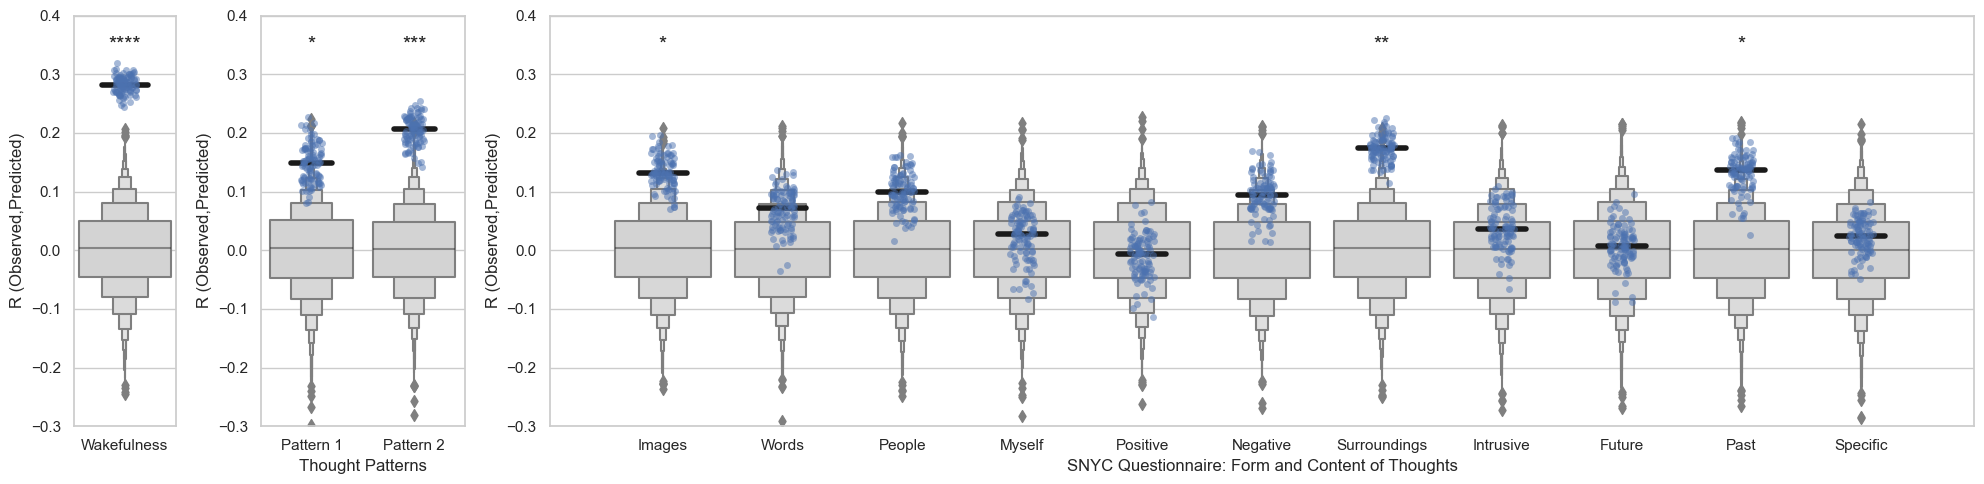

In [19]:
median_width = 0.4
sns.set(style='whitegrid')
fig,ax = plt.subplots(1,3 ,figsize=(20,5), gridspec_kw={'width_ratios': [1,2,14]})
# Vigilance
sns.boxenplot(data=null_df[null_df['Question']=='Wakefulness'],x='Question',y='R', color='lightgray', ax=ax[0]) 
sns.stripplot(data=real_df[real_df['Question']=='Wakefulness'],x='Question', y='R', alpha=.5, ax=ax[0])
for tick, text in zip(ax[0].get_xticks(), ax[0].get_xticklabels()):
    # Add Black Line Signaling Median
    question   = text.get_text()
    median_val = accuracy_real[question].median().values[0]
    print(text, '%.2f' % median_val)
    ax[0].plot([tick-median_width/2, tick+median_width/2],[median_val,median_val], lw=4, color='k')
    # Statistical Significant Information
    p = p_values.loc[question,'Non Parametric']
    if 5.00e-02 < p <= 1.00e+00:
        annot = '' 
    elif 1.00e-02 < p <= 5.00e-02:
        annot = '*'
    elif 1.00e-03 < p <= 1.00e-02:
        annot = '**'
    elif 1.00e-04 < p <= 1.00e-03:
        annot = '***'
    elif p <= 1.00e-04:
        annot = '****'
    max_val = real_df.set_index('Question').max()['R']
    ax[0].annotate(annot, xy=(tick, max_val+0.02), ha='center', fontsize=15)
    
ax[0].set_ylim(-.3,.4)
ax[0].set_ylabel('R (Observed,Predicted)');
ax[0].set_xlabel('')

# Factors
sns.boxenplot(data=null_df[(null_df['Question']=='Thought Pattern 1') | (null_df['Question']=='Thought Pattern 2')],x='Question', y='R', color='lightgray', ax=ax[1]) 
sns.stripplot(data=real_df[(real_df['Question']=='Thought Pattern 1') | (real_df['Question']=='Thought Pattern 2')],x='Question', y='R', alpha=.5, ax=ax[1])
for tick, text in zip(ax[1].get_xticks(), ax[1].get_xticklabels()):
    # Add Black Line Signaling Median
    question   = text.get_text()
    median_val = accuracy_real[question].median().values[0]
    print(text, '%.2f' % median_val)
    ax[1].plot([tick-median_width/2, tick+median_width/2],[median_val,median_val], lw=4, color='k')
    # Statistical Significant Information
    p = p_values.loc[question,'Non Parametric']
    if 5.00e-02 < p <= 1.00e+00:
        annot = '' 
    elif 1.00e-02 < p <= 5.00e-02:
        annot = '*'
    elif 1.00e-03 < p <= 1.00e-02:
        annot = '**'
    elif 1.00e-04 < p <= 1.00e-03:
        annot = '***'
    elif p <= 1.00e-04:
        annot = '****'
    max_val = real_df.set_index('Question').max()['R']
    ax[1].annotate(annot, xy=(tick, max_val+0.02), ha='center', fontsize=15)
ax[1].set_xticklabels(['Pattern 1','Pattern 2'])
ax[1].set_ylim(-.3,.4)
ax[1].set_ylabel('R (Observed,Predicted)');
ax[1].set_xlabel('Thought Patterns')

# Individual Iterms
sns.boxenplot(data=null_df[(null_df['Question']!='Thought Pattern 1') & (null_df['Question']!='Thought Pattern 2') & (null_df['Question']!='Wakefulness')],x='Question', y='R', color='lightgray', ax=ax[2]) 
sns.stripplot(data=real_df[(real_df['Question']!='Thought Pattern 1') & (real_df['Question']!='Thought Pattern 2') & (real_df['Question']!='Wakefulness')],x='Question', y='R', alpha=.5, ax=ax[2])
for tick, text in zip(ax[2].get_xticks(), ax[2].get_xticklabels()):
    # Add Black Line Signaling Median
    question   = text.get_text()
    median_val = accuracy_real[question].median().values[0]
    ax[2].plot([tick-median_width/2, tick+median_width/2],[median_val,median_val], lw=4, color='k')
    # Statistical Significant Information
    p = p_values.loc[question,'Non Parametric']
    if 5.00e-02 < p <= 1.00e+00:
        annot = '' 
    elif 1.00e-02 < p <= 5.00e-02:
        annot = '*'
        print(text, '%.2f' % median_val)
    elif 1.00e-03 < p <= 1.00e-02:
        annot = '**'
        print(text, '%.2f' % median_val)
    elif 1.00e-04 < p <= 1.00e-03:
        annot = '***'
        print(text, '%.2f' % median_val)
    elif p <= 1.00e-04:
        annot = '****'
        print(text, '%.2f' % median_val)
    max_val = real_df.set_index('Question').max()['R']
    ax[2].annotate(annot, xy=(tick, max_val+0.02), ha='center', fontsize=15)
    
ax[2].set_ylim(-.3,.4)
ax[2].set_ylabel('R (Observed,Predicted)');
ax[2].set_xlabel('SNYC Questionnaire: Form and Content of Thoughts')
plt.tight_layout()

Text(0, 0, 'Wakefulness') 0.28
Text(0, 0, 'Thought Pattern 1') 0.15
Text(1, 0, 'Thought Pattern 2') 0.21
Text(0, 0, 'Images') 0.13
Text(1, 0, 'Surroundings') 0.17
Text(2, 0, 'Past') 0.14


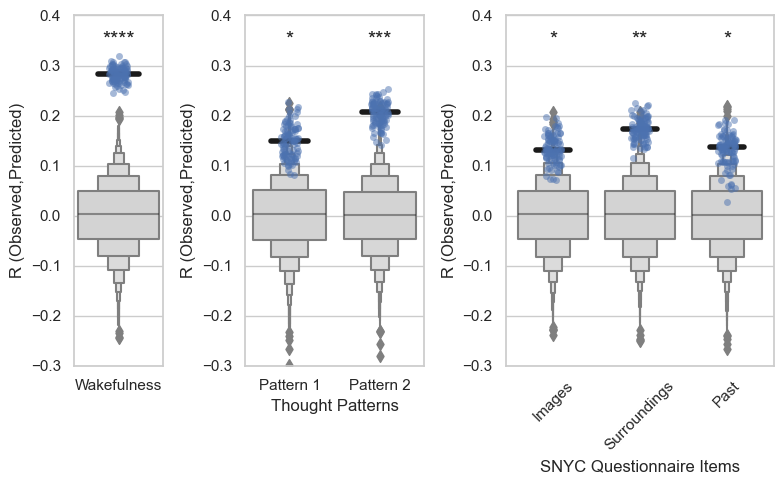

In [21]:
median_width = 0.4
sns.set(style='whitegrid')
fig,ax = plt.subplots(1,3 ,figsize=(8,5), gridspec_kw={'width_ratios': [1,2,3]})
# Vigilance
sns.boxenplot(data=null_df[null_df['Question']=='Wakefulness'],x='Question',y='R', color='lightgray', ax=ax[0]) 
sns.stripplot(data=real_df[real_df['Question']=='Wakefulness'],x='Question', y='R', alpha=.5, ax=ax[0])
plt.xticks(rotation=45);
for tick, text in zip(ax[0].get_xticks(), ax[0].get_xticklabels()):
    # Add Black Line Signaling Median
    question   = text.get_text()
    median_val = accuracy_real[question].median().values[0]
    print(text, '%.2f' % median_val)
    ax[0].plot([tick-median_width/2, tick+median_width/2],[median_val,median_val], lw=4, color='k')
    # Statistical Significant Information
    p = p_values.loc[question,'Non Parametric']
    if 5.00e-02 < p <= 1.00e+00:
        annot = '' 
    elif 1.00e-02 < p <= 5.00e-02:
        annot = '*'
    elif 1.00e-03 < p <= 1.00e-02:
        annot = '**'
    elif 1.00e-04 < p <= 1.00e-03:
        annot = '***'
    elif p <= 1.00e-04:
        annot = '****'
    max_val = real_df.set_index('Question').max()['R']
    ax[0].annotate(annot, xy=(tick, max_val+0.02), ha='center', fontsize=15)
    
ax[0].set_ylim(-.3,.4)
ax[0].set_ylabel('R (Observed,Predicted)');
ax[0].set_xlabel('')

# Factors
sns.boxenplot(data=null_df[(null_df['Question']=='Thought Pattern 1') | (null_df['Question']=='Thought Pattern 2')],x='Question',y='R', color='lightgray', ax=ax[1]) 
sns.stripplot(data=real_df[(real_df['Question']=='Thought Pattern 1') | (real_df['Question']=='Thought Pattern 2')],x='Question', y='R', alpha=.5, ax=ax[1])
plt.xticks(rotation=45);
for tick, text in zip(ax[1].get_xticks(), ax[1].get_xticklabels()):
    # Add Black Line Signaling Median
    question   = text.get_text()
    median_val = accuracy_real[question].median().values[0]
    print(text, '%.2f' % median_val)
    ax[1].plot([tick-median_width/2, tick+median_width/2],[median_val,median_val], lw=4, color='k')
    # Statistical Significant Information
    p = p_values.loc[question,'Non Parametric']
    if 5.00e-02 < p <= 1.00e+00:
        annot = '' 
    elif 1.00e-02 < p <= 5.00e-02:
        annot = '*'
    elif 1.00e-03 < p <= 1.00e-02:
        annot = '**'
    elif 1.00e-04 < p <= 1.00e-03:
        annot = '***'
    elif p <= 1.00e-04:
        annot = '****'
    max_val = real_df.set_index('Question').max()['R']
    ax[1].annotate(annot, xy=(tick, max_val+0.02), ha='center', fontsize=15)

ax[1].set_ylim(-.3,.4)
ax[1].set_xticklabels(['Pattern 1','Pattern 2'])
ax[1].set_ylabel('R (Observed,Predicted)');
ax[1].set_xlabel('Thought Patterns')

# Significant Individual Iterms
sns.boxenplot(data=null_df[(null_df['Question']=='Images') | (null_df['Question']=='Surroundings') | (null_df['Question']=='Past')],x='Question',y='R', color='lightgray', ax=ax[2]) 
sns.stripplot(data=real_df[(real_df['Question']=='Images') | (real_df['Question']=='Surroundings') | (real_df['Question']=='Past')],x='Question', y='R', alpha=.5, ax=ax[2])
plt.xticks(rotation=45);
for tick, text in zip(ax[2].get_xticks(), ax[2].get_xticklabels()):
    # Add Black Line Signaling Median
    question   = text.get_text()
    median_val = accuracy_real[question].median().values[0]
    ax[2].plot([tick-median_width/2, tick+median_width/2],[median_val,median_val], lw=4, color='k')
    # Statistical Significant Information
    p = p_values.loc[question,'Non Parametric']
    if 5.00e-02 < p <= 1.00e+00:
        annot = '' 
    elif 1.00e-02 < p <= 5.00e-02:
        annot = '*'
        print(text, '%.2f' % median_val)
    elif 1.00e-03 < p <= 1.00e-02:
        annot = '**'
        print(text, '%.2f' % median_val)
    elif 1.00e-04 < p <= 1.00e-03:
        annot = '***'
        print(text, '%.2f' % median_val)
    elif p <= 1.00e-04:
        annot = '****'
        print(text, '%.2f' % median_val)
    max_val = real_df.set_index('Question').max()['R']
    ax[2].annotate(annot, xy=(tick, max_val+0.02), ha='center', fontsize=15)
    
ax[2].set_ylim(-.3,.4)
ax[2].set_ylabel('R (Observed,Predicted)');
ax[2].set_xlabel('SNYC Questionnaire Items')
plt.tight_layout()

In [22]:
fig.savefig('./figures/S17_CPM_subject_aware-PredictionAccuracy.png')

## 4.3. Scatter Plots of Observed vs. Predicted Values

In [23]:
N_sign_results = (p_values.loc[:,'Non Parametric'] < 0.05).sum()
print('++ INFO: Number of items predicted significantly: %d ' % N_sign_results)

++ INFO: Number of items predicted significantly: 6 


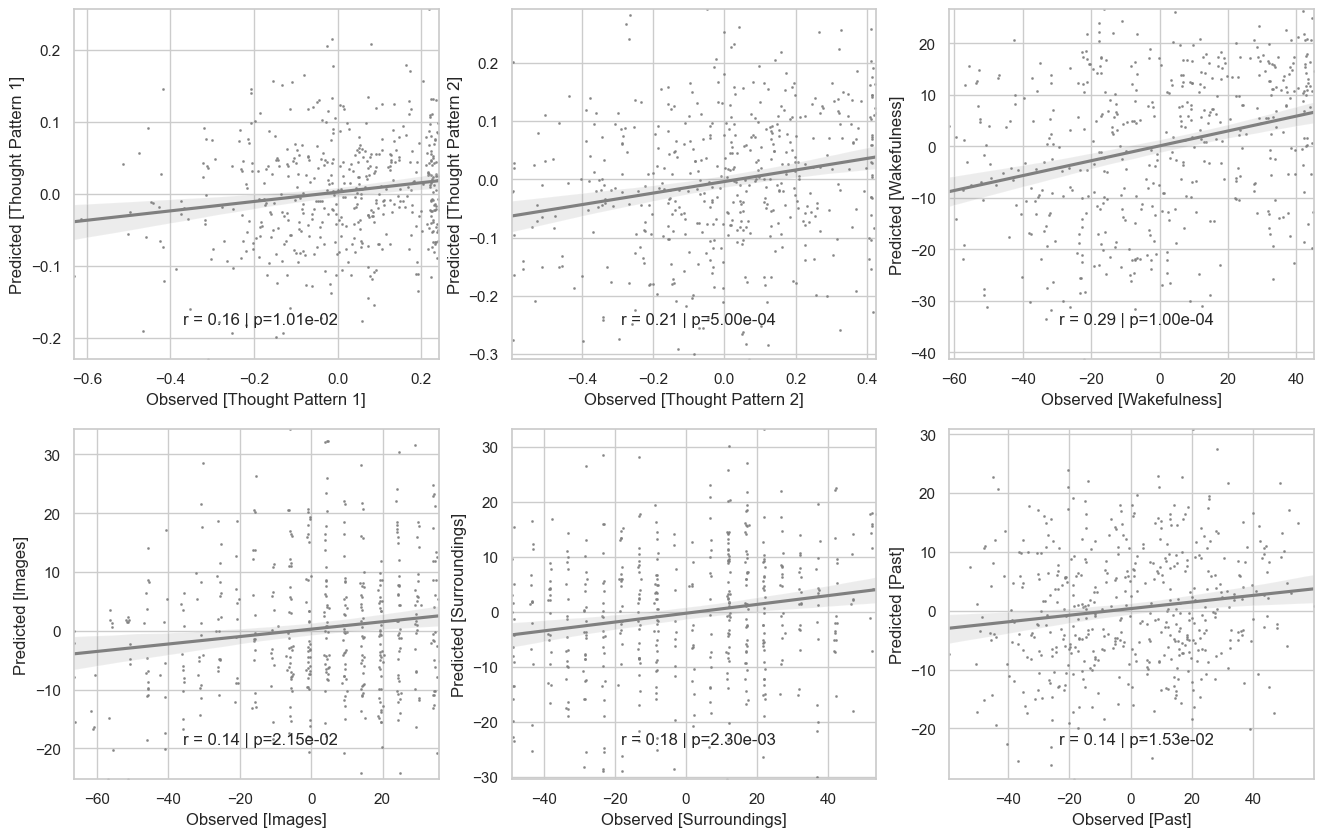

In [24]:
fig,ax = plt.subplots(2,int(N_sign_results/2),figsize=(16,10))
i = 0
for BEHAVIOR in BEHAVIOR_LABELS:
    p = p_values.loc[BEHAVIOR,'Non Parametric']
    if p <= 0.05:
        row,col        = np.unravel_index(i,(2,int(N_sign_results/2)))
        behav_obs_pred = pd.DataFrame(real_predictions_xr.median(dim='Iteration').loc[BEHAVIOR,:,['observed','predicted (glm)']], columns=['observed','predicted (glm)'])
        r,p = plot_predictions(behav_obs_pred, ax=ax[row,col], xlabel='Observed [%s]' % BEHAVIOR, ylabel='Predicted [%s]' % BEHAVIOR, font_scale=1,p_value=p_values.loc[BEHAVIOR,'Non Parametric'], 
                               ylim=(behav_obs_pred['predicted (glm)'].min().values, behav_obs_pred['predicted (glm)'].max().values),
                               xlim=(behav_obs_pred['observed'].min().values, behav_obs_pred['observed'].max().values))
        i= i + 1

In [25]:
plt.tight_layout()
fig.savefig('./figures/S17_CPM_subject_aware-ScatterPlots.png')

<Figure size 640x480 with 0 Axes>